### Import Packages

In [109]:
# Basics
import pandas as pd
import numpy as np
pd.set_option('display.max_rows', 1000)
from datetime import datetime as dt
import itertools

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('ggplot')
from statsmodels.tsa.seasonal import seasonal_decompose

# Time-Series statsmodels
from sklearn.model_selection import TimeSeriesSplit
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import acf, pacf, adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Testing
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import mean_squared_error

# Warnings
import warnings
from statsmodels.tools.sm_exceptions import ConvergenceWarning, ValueWarning
warnings.simplefilter('ignore', ConvergenceWarning)
warnings.simplefilter('ignore', ValueWarning)

### Load the data

In [2]:
!pwd

/Users/Alice/Documents/Omdena/Local Chapters - Chennai/chennai-india-power-outage/src/tasks/task-06-Model Building


In [3]:
# load in outage data as df
df = pd.read_csv('../../data/cleaned data/demand_supply_monthly.csv')
df.head()

,Requirement(MU/DAY),Energy_met(MU/DAY),Surplus(+)/Deficit(-)(MU/DAY),Requirement(MU),Energy_met(MU),Surplus(+)/Deficit(-)(MU),%Shortage(MU),Requirement(MW),Peak_Demand_Met5(MW),Surplus(+)/Deficit(-)(MW),%Shortage(MW),name_report,year,month,date_published,month_published,year_published
0,354.0,354.0,-0.9,10632.0,10605.0,-26.0,-0.2,17646.0,17563.0,-83.0,-0.5,Monthly_Report_Apr_2022,2022,4,2022-05-23,5,2022
1,337.0,337.0,0.0,10459.0,10458.0,-1.0,0.0,16906.0,16906.0,0.0,0.0,Monthly_Report_May_2022,2022,5,2022-06-23,6,2022
2,344.0,343.0,-0.3,10657.0,10648.0,-9.0,-0.1,17196.0,17196.0,0.0,0.0,Monthly_Report_Mar_2022,2022,3,2022-04-25,4,2022
3,286.0,286.0,0.0,8873.0,8873.0,1.0,0.0,15290.0,15290.0,0.0,0.0,Monthly_Report_Jan_2022,2022,1,2022-02-23,2,2022
4,245.0,245.0,0.0,7362.0,7360.0,-1.0,0.0,13501.0,13480.0,-21.0,-0.2,Monthly_Report_Nov_2021,2021,11,2021-12-23,12,2021


In [4]:
df.info(verbose=True, null_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 122 entries, 0 to 121
Data columns (total 17 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   Requirement(MU/DAY)            122 non-null    float64
 1   Energy_met(MU/DAY)             122 non-null    float64
 2   Surplus(+)/Deficit(-)(MU/DAY)  122 non-null    float64
 3   Requirement(MU)                122 non-null    float64
 4   Energy_met(MU)                 122 non-null    float64
 5   Surplus(+)/Deficit(-)(MU)      122 non-null    float64
 6   %Shortage(MU)                  122 non-null    float64
 7   Requirement(MW)                122 non-null    float64
 8   Peak_Demand_Met5(MW)           122 non-null    float64
 9   Surplus(+)/Deficit(-)(MW)      122 non-null    float64
 10  %Shortage(MW)                  122 non-null    float64
 11  name_report                    122 non-null    object 
 12  year                           122 non-null    int

In [5]:
df.describe()

,Requirement(MU/DAY),Energy_met(MU/DAY),Surplus(+)/Deficit(-)(MU/DAY),Requirement(MU),Energy_met(MU),Surplus(+)/Deficit(-)(MU),%Shortage(MU),Requirement(MW),Peak_Demand_Met5(MW),Surplus(+)/Deficit(-)(MW),%Shortage(MW),year,month,month_published,year_published
count,122.000000,122.000000,122.000000,122.000000,122.000000,122.000000,122.000000,122.000000,122.000000,122.000000,122.000000,122.000000,122.000000,122.000000,122.000000
mean,283.758197,276.782787,-6.989344,8631.884426,8419.755738,-212.110656,-2.718033,14066.011475,13849.101639,-216.893443,-1.734426,2016.836066,6.467213,6.598361,2017.131148
std,27.948258,36.694300,14.425527,864.073361,1127.604563,438.266568,5.696266,1470.967073,1771.175005,583.523308,4.757991,2.969155,3.447803,3.271868,2.721056
min,217.000000,177.000000,-60.000000,6511.100000,5302.000000,-1860.000000,-24.000000,10161.000000,8518.000000,-3745.000000,-28.000000,2012.000000,1.000000,1.000000,2013.000000
25%,264.500000,254.000000,-7.000000,7994.750000,7759.750000,-216.525000,-2.825000,12969.000000,12732.000000,-161.250000,-1.250000,2014.000000,4.000000,4.000000,2014.000000
50%,280.500000,279.050000,-0.200000,8534.100000,8431.000000,-5.450000,-0.100000,14290.500000,14225.500000,-23.000000,-0.200000,2017.000000,6.000000,7.000000,2017.000000
75%,302.875000,302.800000,0.000000,9201.150000,9201.650000,-0.750000,0.000000,15024.500000,15007.250000,0.000000,0.000000,2019.000000,9.000000,9.000000,2019.000000
max,354.000000,354.000000,0.100000,10657.000000,10648.000000,3.000000,0.000000,17646.000000,17563.000000,2360.000000,20.700000,2022.000000,12.000000,12.000000,2022.000000


## Time Series Data

### Prepare time series data

In [6]:
df.head()

,Requirement(MU/DAY),Energy_met(MU/DAY),Surplus(+)/Deficit(-)(MU/DAY),Requirement(MU),Energy_met(MU),Surplus(+)/Deficit(-)(MU),%Shortage(MU),Requirement(MW),Peak_Demand_Met5(MW),Surplus(+)/Deficit(-)(MW),%Shortage(MW),name_report,year,month,date_published,month_published,year_published
0,354.0,354.0,-0.9,10632.0,10605.0,-26.0,-0.2,17646.0,17563.0,-83.0,-0.5,Monthly_Report_Apr_2022,2022,4,2022-05-23,5,2022
1,337.0,337.0,0.0,10459.0,10458.0,-1.0,0.0,16906.0,16906.0,0.0,0.0,Monthly_Report_May_2022,2022,5,2022-06-23,6,2022
2,344.0,343.0,-0.3,10657.0,10648.0,-9.0,-0.1,17196.0,17196.0,0.0,0.0,Monthly_Report_Mar_2022,2022,3,2022-04-25,4,2022
3,286.0,286.0,0.0,8873.0,8873.0,1.0,0.0,15290.0,15290.0,0.0,0.0,Monthly_Report_Jan_2022,2022,1,2022-02-23,2,2022
4,245.0,245.0,0.0,7362.0,7360.0,-1.0,0.0,13501.0,13480.0,-21.0,-0.2,Monthly_Report_Nov_2021,2021,11,2021-12-23,12,2021


In [7]:
# data frame is clean, no nulls
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 122 entries, 0 to 121
Data columns (total 17 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   Requirement(MU/DAY)            122 non-null    float64
 1   Energy_met(MU/DAY)             122 non-null    float64
 2   Surplus(+)/Deficit(-)(MU/DAY)  122 non-null    float64
 3   Requirement(MU)                122 non-null    float64
 4   Energy_met(MU)                 122 non-null    float64
 5   Surplus(+)/Deficit(-)(MU)      122 non-null    float64
 6   %Shortage(MU)                  122 non-null    float64
 7   Requirement(MW)                122 non-null    float64
 8   Peak_Demand_Met5(MW)           122 non-null    float64
 9   Surplus(+)/Deficit(-)(MW)      122 non-null    float64
 10  %Shortage(MW)                  122 non-null    float64
 11  name_report                    122 non-null    object 
 12  year                           122 non-null    int

In [8]:
df.index

RangeIndex(start=0, stop=122, step=1)

In [9]:
#create unique dates using year and month column
df['year']=df['year'].astype(str)
df['month']=df['month'].astype(str)
df['ts_date'] = df[['year', 'month']].agg('-'.join, axis=1)
df['ts_date'] = pd.to_datetime(df['ts_date'], format = '%Y-%m')

In [10]:
df.head()

,Requirement(MU/DAY),Energy_met(MU/DAY),Surplus(+)/Deficit(-)(MU/DAY),Requirement(MU),Energy_met(MU),Surplus(+)/Deficit(-)(MU),%Shortage(MU),Requirement(MW),Peak_Demand_Met5(MW),Surplus(+)/Deficit(-)(MW),%Shortage(MW),name_report,year,month,date_published,month_published,year_published,ts_date
0,354.0,354.0,-0.9,10632.0,10605.0,-26.0,-0.2,17646.0,17563.0,-83.0,-0.5,Monthly_Report_Apr_2022,2022,4,2022-05-23,5,2022,2022-04-01
1,337.0,337.0,0.0,10459.0,10458.0,-1.0,0.0,16906.0,16906.0,0.0,0.0,Monthly_Report_May_2022,2022,5,2022-06-23,6,2022,2022-05-01
2,344.0,343.0,-0.3,10657.0,10648.0,-9.0,-0.1,17196.0,17196.0,0.0,0.0,Monthly_Report_Mar_2022,2022,3,2022-04-25,4,2022,2022-03-01
3,286.0,286.0,0.0,8873.0,8873.0,1.0,0.0,15290.0,15290.0,0.0,0.0,Monthly_Report_Jan_2022,2022,1,2022-02-23,2,2022,2022-01-01
4,245.0,245.0,0.0,7362.0,7360.0,-1.0,0.0,13501.0,13480.0,-21.0,-0.2,Monthly_Report_Nov_2021,2021,11,2021-12-23,12,2021,2021-11-01


In [11]:
# set index
df = df.set_index(['ts_date'])

In [12]:
df.head()

,Requirement(MU/DAY),Energy_met(MU/DAY),Surplus(+)/Deficit(-)(MU/DAY),Requirement(MU),Energy_met(MU),Surplus(+)/Deficit(-)(MU),%Shortage(MU),Requirement(MW),Peak_Demand_Met5(MW),Surplus(+)/Deficit(-)(MW),%Shortage(MW),name_report,year,month,date_published,month_published,year_published
ts_date,,,,,,,,,,,,,,,,,
2022-04-01,354.0,354.0,-0.9,10632.0,10605.0,-26.0,-0.2,17646.0,17563.0,-83.0,-0.5,Monthly_Report_Apr_2022,2022,4,2022-05-23,5,2022
2022-05-01,337.0,337.0,0.0,10459.0,10458.0,-1.0,0.0,16906.0,16906.0,0.0,0.0,Monthly_Report_May_2022,2022,5,2022-06-23,6,2022
2022-03-01,344.0,343.0,-0.3,10657.0,10648.0,-9.0,-0.1,17196.0,17196.0,0.0,0.0,Monthly_Report_Mar_2022,2022,3,2022-04-25,4,2022
2022-01-01,286.0,286.0,0.0,8873.0,8873.0,1.0,0.0,15290.0,15290.0,0.0,0.0,Monthly_Report_Jan_2022,2022,1,2022-02-23,2,2022
2021-11-01,245.0,245.0,0.0,7362.0,7360.0,-1.0,0.0,13501.0,13480.0,-21.0,-0.2,Monthly_Report_Nov_2021,2021,11,2021-12-23,12,2021


In [13]:
df.columns

Index(['Requirement(MU/DAY)', 'Energy_met(MU/DAY)',
       'Surplus(+)/Deficit(-)(MU/DAY)', 'Requirement(MU)', 'Energy_met(MU)',
       'Surplus(+)/Deficit(-)(MU)', '%Shortage(MU)', 'Requirement(MW)',
       'Peak_Demand_Met5(MW)', 'Surplus(+)/Deficit(-)(MW)', '%Shortage(MW)',
       'name_report', 'year', 'month', 'date_published', 'month_published',
       'year_published'],
      dtype='object')

In [14]:
# delete all extra columns from the dataframe
ts = df.drop(columns=['Requirement(MU/DAY)', 'Energy_met(MU/DAY)',
       'Surplus(+)/Deficit(-)(MU/DAY)', 'Requirement(MW)',
       'Peak_Demand_Met5(MW)', 'Surplus(+)/Deficit(-)(MW)', '%Shortage(MW)',
       'name_report', 'year', 'month', 'date_published', 'month_published',
       'year_published'])

In [15]:
ts.head()

,Requirement(MU),Energy_met(MU),Surplus(+)/Deficit(-)(MU),%Shortage(MU)
ts_date,,,,
2022-04-01,10632.0,10605.0,-26.0,-0.2
2022-05-01,10459.0,10458.0,-1.0,0.0
2022-03-01,10657.0,10648.0,-9.0,-0.1
2022-01-01,8873.0,8873.0,1.0,0.0
2021-11-01,7362.0,7360.0,-1.0,0.0


## Investigating Time Series with Datetime Objects

Datetime objects include aspects of the date as attributes, like month and year:

In [16]:
# Entire
ts.index[0]

Timestamp('2022-04-01 00:00:00')

In [17]:
# Day
ts.index[0].day

1

In [18]:
# Month
ts.index[0].month

4

In [19]:
# Year
ts.index[0].year

2022

In [20]:
# Sort and reset index
ts = ts.sort_index()

In [21]:
ts.head()

,Requirement(MU),Energy_met(MU),Surplus(+)/Deficit(-)(MU),%Shortage(MU)
ts_date,,,,
2012-04-01,7707.0,5940.0,-1767.0,-23.0
2012-05-01,7605.0,6649.0,-956.0,-13.0
2012-06-01,7928.0,6893.0,-1035.0,-13.0
2012-07-01,7981.0,7272.0,-709.0,-9.0
2012-08-01,7851.0,6773.0,-1078.0,-14.0


In [22]:
# check if the index is unique

ts.index.is_unique

True

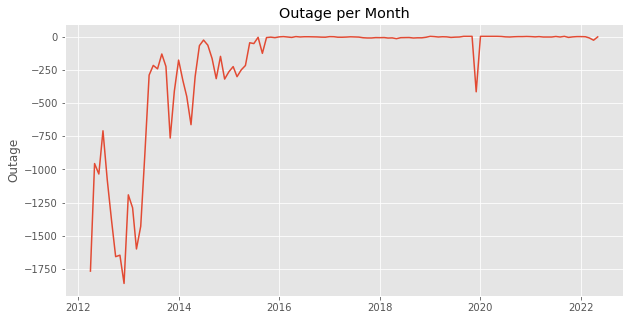

In [23]:
# visualize the time series 

fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(ts.index, ts['Surplus(+)/Deficit(-)(MU)'])
ax.set_title('Outage per Month')
ax.set_ylabel('Outage');

In [24]:
timeperiod = ts[ts.index > '2018-12-01']
timeperiod

,Requirement(MU),Energy_met(MU),Surplus(+)/Deficit(-)(MU),%Shortage(MU)
ts_date,,,,
2019-01-01,8681.0,8684.0,3.0,0.0
2019-02-01,8746.0,8747.0,1.0,0.0
2019-03-01,10548.0,10546.0,-2.0,0.0
2019-04-01,10308.0,10308.0,0.0,0.0
2019-05-01,10612.0,10611.0,-1.0,0.0
2019-06-01,10051.0,10046.0,-5.0,0.0
2019-07-01,9841.0,9838.0,-3.0,0.0
2019-08-01,9171.0,9169.0,-2.0,0.0
2019-09-01,8633.0,8636.0,3.0,0.0


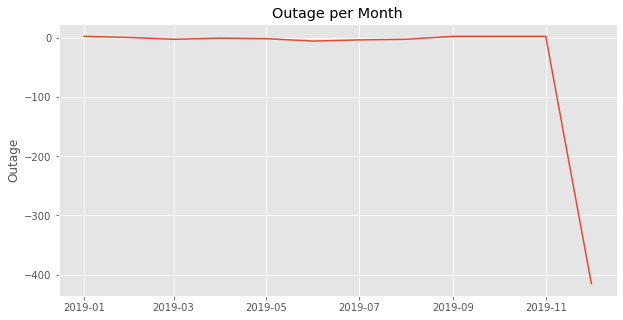

In [25]:
# check the major dip in 2019

fig, ax = plt.subplots(figsize=(10, 5))
timeperiod = ts[(ts.index > '2018-12-01') & (ts.index < '2020-01-01')]
ax.plot(timeperiod.index, timeperiod['Surplus(+)/Deficit(-)(MU)'])
ax.set_title('Outage per Month')
ax.set_ylabel('Outage');

In [26]:
# check the column for 2019-12 month

ts[ts.index == '2019-12-01']

# is this a data error or an outlier?

,Requirement(MU),Energy_met(MU),Surplus(+)/Deficit(-)(MU),%Shortage(MU)
ts_date,,,,
2019-12-01,8246.0,7831.0,-415.0,-5.0


In [27]:
# create time series data with only date as index and Surplus/Deficit as the only column

ts_new = ts['Surplus(+)/Deficit(-)(MU)']
ts_new

ts_date
2012-04-01   -1767.0
2012-05-01    -956.0
2012-06-01   -1035.0
2012-07-01    -709.0
2012-08-01   -1078.0
2012-09-01   -1383.0
2012-10-01   -1658.0
2012-11-01   -1647.0
2012-12-01   -1860.0
2013-01-01   -1192.0
2013-02-01   -1290.0
2013-03-01   -1600.0
2013-04-01   -1429.0
2013-05-01    -885.0
2013-06-01    -289.0
2013-07-01    -216.0
2013-08-01    -242.0
2013-09-01    -130.0
2013-10-01    -224.0
2013-11-01    -764.0
2013-12-01    -410.0
2014-01-01    -176.0
2014-02-01    -330.0
2014-03-01    -450.0
2014-04-01    -663.0
2014-05-01    -300.0
2014-06-01     -67.0
2014-07-01     -25.0
2014-08-01     -63.5
2014-09-01    -164.3
2014-10-01    -316.0
2014-11-01    -147.8
2014-12-01    -319.0
2015-01-01    -264.0
2015-02-01    -225.0
2015-03-01    -301.0
2015-04-01    -249.2
2015-05-01    -216.7
2015-06-01     -45.2
2015-07-01     -51.4
2015-08-01      -4.2
2015-09-01    -125.2
2015-10-01      -6.2
2015-11-01      -2.9
2015-12-01      -6.9
2016-01-01      -0.9
2016-02-01       1.0
2016-

<AxesSubplot:xlabel='ts_date'>

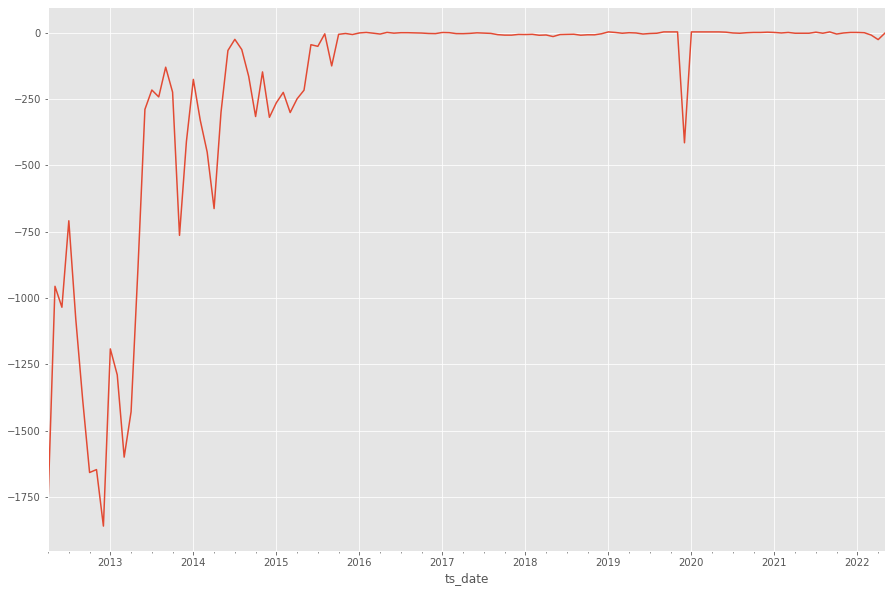

In [28]:
# lineplot

ts_new.plot(figsize=(15,10))

In [37]:
# Generate a box and whiskers plot for ts_new dataframe to see the distribution over time

year_groups = ts_new[(ts_new.index>'2012-12-01') & (ts_new.index<'2022-01-01')].groupby(pd.Grouper(freq='A'))
ts_annual = pd.DataFrame()

for yr, group in year_groups:
    ts_annual[yr.year] = group.values.ravel()
ts_annual

,2013,2014,2015,2016,2017,2018,2019,2020,2021
0,-1192.0,-176.0,-264.0,-0.9,0.8,-6.9,3.0,3.0,1.0
1,-1290.0,-330.0,-225.0,1.0,0.2,-6.1,1.0,3.0,-1.0
2,-1600.0,-450.0,-301.0,-1.8,-3.4,-9.6,-2.0,3.0,1.0
3,-1429.0,-663.0,-249.2,-5.1,-3.6,-8.6,0.0,3.0,-2.0
4,-885.0,-300.0,-216.7,1.2,-2.5,-14.5,-1.0,3.0,-2.0
5,-289.0,-67.0,-45.2,-1.7,-0.5,-7.0,-5.0,2.0,-2.0
6,-216.0,-25.0,-51.4,0.0,-1.5,-6.3,-3.0,-1.0,2.0
7,-242.0,-63.5,-4.2,0.0,-2.6,-5.8,-2.0,-2.0,-2.0
8,-130.0,-164.3,-125.2,-0.7,-7.4,-9.4,3.0,0.0,3.0
9,-224.0,-316.0,-6.2,-1.3,-9.1,-7.9,3.0,1.0,-5.0


<AxesSubplot:>

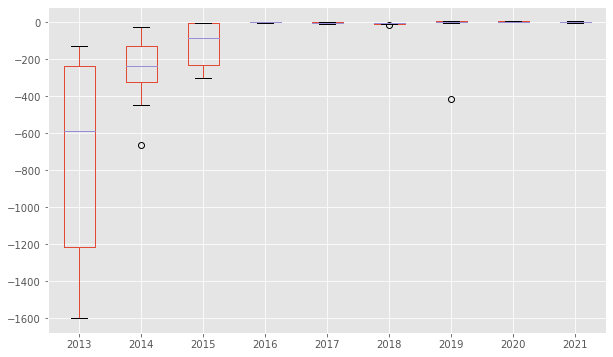

In [38]:
ts_annual.boxplot(figsize=(10,6))

#### Dickey-Fuller Test

In [39]:
def display_df(dftest):
    '''
    Display the output from a Dickey-Fuller test in a more readable format
    '''
    
    
    dfoutput = pd.Series(
                dftest[0:4], 
                index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])

    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value

    display(dfoutput)

In [42]:
# Dickey-Fuller

dftest = adfuller(ts_new)

In [43]:
dftest

(-10.702085518665958,
 3.502339063511743e-19,
 12,
 109,
 {'1%': -3.49181775886872,
  '5%': -2.8884437992971588,
  '10%': -2.5811201893779985},
 1255.7726419747537)

In [44]:
display_df(dftest)

Test Statistic                -1.070209e+01
p-value                        3.502339e-19
#Lags Used                     1.200000e+01
Number of Observations Used    1.090000e+02
Critical Value (1%)           -3.491818e+00
Critical Value (5%)           -2.888444e+00
Critical Value (10%)          -2.581120e+00
dtype: float64

Interpretation:
<br>
- The p-value is smaller than 0.05 so we reject the null hypothesis and consider data as stationary.

#### Time Series Decomposition

In [55]:
# Decompose it!

decomposition = seasonal_decompose(ts_new)

In [56]:
decomposition

In [57]:
trend = decomposition.trend

In [58]:
seasonal = decomposition.seasonal

In [59]:
residual = decomposition.resid

In [60]:
trend

ts_date
2012-04-01            NaN
2012-05-01            NaN
2012-06-01            NaN
2012-07-01            NaN
2012-08-01            NaN
2012-09-01            NaN
2012-10-01   -1333.833333
2012-11-01   -1316.791667
2012-12-01   -1282.750000
2013-01-01   -1231.125000
2013-02-01   -1175.750000
2013-03-01   -1088.708333
2013-04-01    -976.750000
2013-05-01    -880.208333
2013-06-01    -783.000000
2013-07-01    -680.250000
2013-08-01    -597.916667
2013-09-01    -510.000000
2013-10-01    -430.166667
2013-11-01    -373.875000
2013-12-01    -340.250000
2014-01-01    -323.041667
2014-02-01    -307.645833
2014-03-01    -301.637500
2014-04-01    -306.900000
2014-05-01    -285.058333
2014-06-01    -255.591667
2014-07-01    -255.466667
2014-08-01    -254.758333
2014-09-01    -244.175000
2014-10-01    -220.725000
2014-11-01    -200.012500
2014-12-01    -195.633333
2015-01-01    -195.825000
2015-02-01    -194.454167
2015-03-01    -190.354167
2015-04-01    -175.816667
2015-05-01    -156.870833
2015

In [61]:
# Gather the trend, seasonality and noise of decomposed object

decomposition.observed

ts_date
2012-04-01   -1767.0
2012-05-01    -956.0
2012-06-01   -1035.0
2012-07-01    -709.0
2012-08-01   -1078.0
2012-09-01   -1383.0
2012-10-01   -1658.0
2012-11-01   -1647.0
2012-12-01   -1860.0
2013-01-01   -1192.0
2013-02-01   -1290.0
2013-03-01   -1600.0
2013-04-01   -1429.0
2013-05-01    -885.0
2013-06-01    -289.0
2013-07-01    -216.0
2013-08-01    -242.0
2013-09-01    -130.0
2013-10-01    -224.0
2013-11-01    -764.0
2013-12-01    -410.0
2014-01-01    -176.0
2014-02-01    -330.0
2014-03-01    -450.0
2014-04-01    -663.0
2014-05-01    -300.0
2014-06-01     -67.0
2014-07-01     -25.0
2014-08-01     -63.5
2014-09-01    -164.3
2014-10-01    -316.0
2014-11-01    -147.8
2014-12-01    -319.0
2015-01-01    -264.0
2015-02-01    -225.0
2015-03-01    -301.0
2015-04-01    -249.2
2015-05-01    -216.7
2015-06-01     -45.2
2015-07-01     -51.4
2015-08-01      -4.2
2015-09-01    -125.2
2015-10-01      -6.2
2015-11-01      -2.9
2015-12-01      -6.9
2016-01-01      -0.9
2016-02-01       1.0
2016-

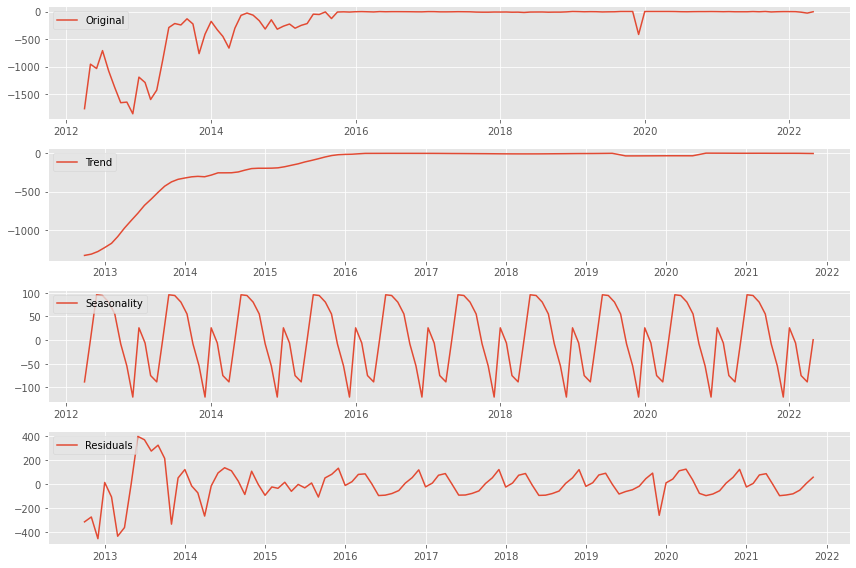

In [65]:
# Plot gathered statistics
plt.figure(figsize=(12, 8))
plt.subplot(411)
plt.plot(ts_new, label='Original')
plt.legend(loc='upper left')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='upper left')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='upper left')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='upper left')
plt.tight_layout()

There is the seasonality component in the data; can check with trend assessment in residuals with a Dickey-Fuller test

In [63]:
# Drop NaN values from residuals.

ts_log_decompose = residual
ts_log_decompose.dropna(inplace=True)

In [64]:
# Really, Dickey-Fuller? Again?

dftest = adfuller(ts_log_decompose)
display_df(dftest)

Test Statistic                 -3.246305
p-value                         0.017456
#Lags Used                     13.000000
Number of Observations Used    96.000000
Critical Value (1%)            -3.500379
Critical Value (5%)            -2.892152
Critical Value (10%)           -2.583100
dtype: float64

The residuals also are stationary

## Modeling

#### Train-Test split

In [74]:
# find the index which allows us to split off 20% of the data
cutoff = round(ts_new.shape[0]*0.8)
cutoff

98

In [76]:
# Define train and test sets according to the index found above
train = ts_new[:cutoff]

test = ts_new[cutoff:]

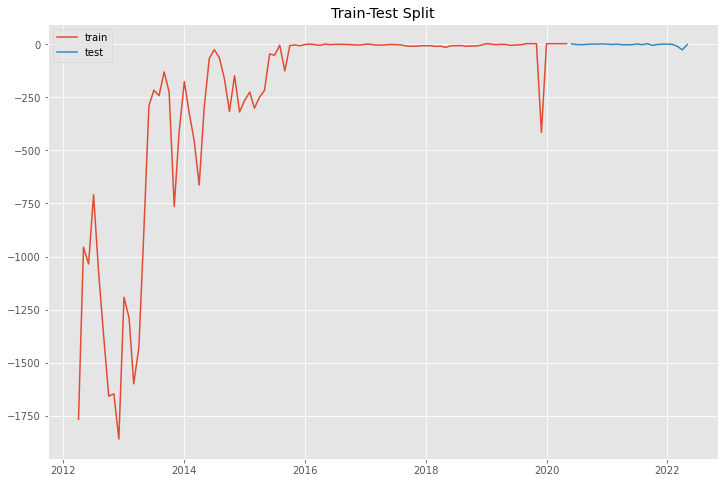

In [77]:
# Plot it!
fig, ax = plt.subplots(figsize=(12, 8))
ax.plot(train, label='train')
ax.plot(test, label='test')
ax.set_title('Train-Test Split');
plt.legend();

#### Cross-validation split

In [78]:
train

ts_date
2012-04-01   -1767.0
2012-05-01    -956.0
2012-06-01   -1035.0
2012-07-01    -709.0
2012-08-01   -1078.0
2012-09-01   -1383.0
2012-10-01   -1658.0
2012-11-01   -1647.0
2012-12-01   -1860.0
2013-01-01   -1192.0
2013-02-01   -1290.0
2013-03-01   -1600.0
2013-04-01   -1429.0
2013-05-01    -885.0
2013-06-01    -289.0
2013-07-01    -216.0
2013-08-01    -242.0
2013-09-01    -130.0
2013-10-01    -224.0
2013-11-01    -764.0
2013-12-01    -410.0
2014-01-01    -176.0
2014-02-01    -330.0
2014-03-01    -450.0
2014-04-01    -663.0
2014-05-01    -300.0
2014-06-01     -67.0
2014-07-01     -25.0
2014-08-01     -63.5
2014-09-01    -164.3
2014-10-01    -316.0
2014-11-01    -147.8
2014-12-01    -319.0
2015-01-01    -264.0
2015-02-01    -225.0
2015-03-01    -301.0
2015-04-01    -249.2
2015-05-01    -216.7
2015-06-01     -45.2
2015-07-01     -51.4
2015-08-01      -4.2
2015-09-01    -125.2
2015-10-01      -6.2
2015-11-01      -2.9
2015-12-01      -6.9
2016-01-01      -0.9
2016-02-01       1.0
2016-

In [81]:
# TimeSeriesSplit
split = TimeSeriesSplit()

for train_ind, val_ind in split.split(train):
    print(f'Train index: {train_ind}')
    print(f'Test  index: {val_ind}')

Train index: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17]
Test  index: [18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33]
Train index: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33]
Test  index: [34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49]
Train index: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49]
Test  index: [50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65]
Train index: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65]
Test  index: [66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81]
Train index: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 5

#### The Baseline Model

In [82]:
baseline = pd.DataFrame(np.hstack((train.values.reshape(-1, 1),
                       train.shift().values.reshape(-1, 1),
                       train.shift(periods=2).values.reshape(-1, 1))),
             columns=['orig', 'shifted_one_period', 'shifted_two_periods'])
baseline.head()

,orig,shifted_one_period,shifted_two_periods
0,-1767.0,NaN,NaN
1,-956.0,-1767.0,NaN
2,-1035.0,-956.0,-1767.0
3,-709.0,-1035.0,-956.0
4,-1078.0,-709.0,-1035.0


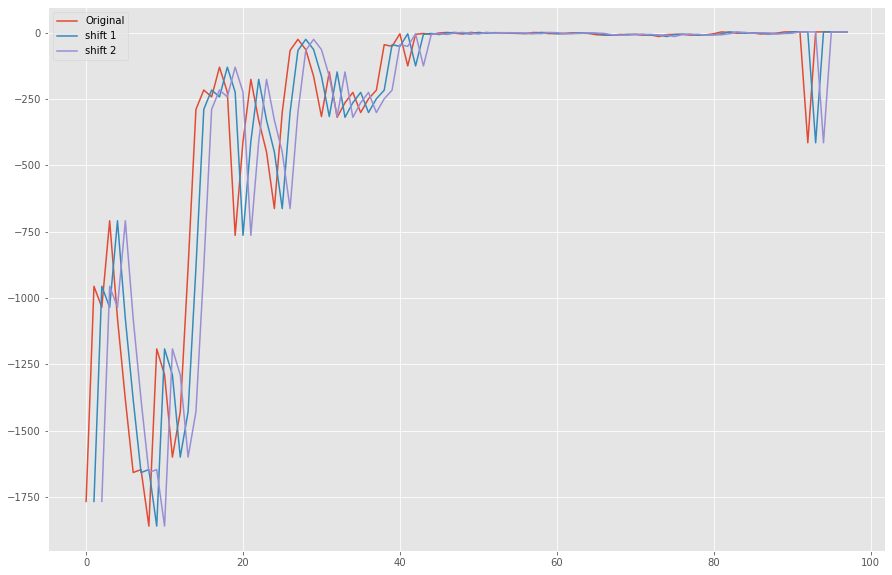

In [83]:
# line plot of the baseline model

ax = baseline['orig'].plot(figsize=(15,10))
baseline['shifted_one_period'].plot()
baseline['shifted_two_periods'].plot()
ax.legend(['Original', 'shift 1', 'shift 2'])
plt.show()

In [84]:
# testing with rmse

rms_shift1 = mean_squared_error(baseline['orig'][1:], baseline['shifted_one_period'][1:], squared=False)
rms_shift2 = mean_squared_error(baseline['orig'][2:], baseline['shifted_two_periods'][2:], squared=False)

In [85]:
rms_shift1

193.7138946737965

In [86]:
rms_shift2

259.60578929086563

#### ARIMA Model

In [89]:
# ar_1 model with differencing
ar_1 = ARIMA(train, order=(1, 1, 0)).fit()

# We put a typ='levels' to convert our predictions to remove the differencing performed.
ar_1.predict(typ='levels')

/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


2012-04-01    0.000000e+00
2012-05-01   -1.764314e+03
2012-06-01   -9.900338e+02
2012-07-01   -1.031685e+03
2012-08-01   -7.226807e+02
2012-09-01   -1.062515e+03
2012-10-01   -1.370201e+03
2012-11-01   -1.646460e+03
2012-12-01   -1.647462e+03
2013-01-01   -1.851061e+03
2013-02-01   -1.220033e+03
2013-03-01   -1.285887e+03
2013-04-01   -1.586991e+03
2013-05-01   -1.436176e+03
2013-06-01   -9.078291e+02
2013-07-01   -3.140113e+02
2013-08-01   -2.190635e+02
2013-09-01   -2.409089e+02
2013-10-01   -1.347001e+02
2013-11-01   -2.200553e+02
2013-12-01   -7.413388e+02
2014-01-01   -4.248557e+02
2014-02-01   -1.858199e+02
2014-03-01   -3.235374e+02
2014-04-01   -4.449642e+02
2014-05-01   -6.540614e+02
2014-06-01   -3.152334e+02
2014-07-01   -7.677790e+01
2014-08-01   -2.676254e+01
2014-09-01   -6.188434e+01
2014-10-01   -1.600699e+02
2014-11-01   -3.096339e+02
2014-12-01   -1.548586e+02
2015-01-01   -3.118155e+02
2015-02-01   -2.663081e+02
2015-03-01   -2.266366e+02
2015-04-01   -2.978106e+02
2

In [91]:
# summary of ar_1
ar_1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                   SARIMAX Results                                   
=====================================================================================
Dep. Variable:     Surplus(+)/Deficit(-)(MU)   No. Observations:                   98
Model:                        ARIMA(1, 1, 0)   Log Likelihood                -648.405
Date:                       Tue, 26 Jul 2022   AIC                           1300.809
Time:                               18:47:49   BIC                           1305.958
Sample:                           04-01-2012   HQIC                          1302.891
                                - 05-01-2020                                         
Covariance Type:                         opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0420      0.071     -0.594      0.552      -0.180       0.096
sigma2      3.752e+04   2868.324     13.079      0.000    3.19e+04    4.31e+04
===================================================================================
Ljung-Box (L1) (Q):                   0.02   Jarque-Bera (JB):               111.54
Prob(Q):                              0.89   Prob(JB):                         0.00
Heteroskedasticity (H):               0.10   Skew:                             1.20
Prob(H) (two-sided):                  0.00   Kurtosis:                         7.67
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

#### Random-walk model

In [92]:
random_walk_model = ARIMA(train, order=(0, 1, 0)).fit()
random_walk_model.summary()

/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


<class 'statsmodels.iolib.summary.Summary'>
"""
                                   SARIMAX Results                                   
=====================================================================================
Dep. Variable:     Surplus(+)/Deficit(-)(MU)   No. Observations:                   98
Model:                        ARIMA(0, 1, 0)   Log Likelihood                -648.476
Date:                       Tue, 26 Jul 2022   AIC                           1298.952
Time:                               18:48:28   BIC                           1301.527
Sample:                           04-01-2012   HQIC                          1299.993
                                - 05-01-2020                                         
Covariance Type:                         opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2      3.753e+04   2879.085     13.035      0.000    3.19e+04    4.32e+04
===================================================================================
Ljung-Box (L1) (Q):                   0.07   Jarque-Bera (JB):               111.05
Prob(Q):                              0.79   Prob(JB):                         0.00
Heteroskedasticity (H):               0.11   Skew:                             1.22
Prob(H) (two-sided):                  0.00   Kurtosis:                         7.63
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

#### Baseline ARIMA model

In [94]:
# Baseline ARIMA model
baseline_ar = ARIMA(train, order=(0,0,0)).fit()
bl_preds = baseline_ar.predict(typ='levels')
bl_rmse = np.sqrt(mean_squared_error(train, bl_preds))
baseline_ar.summary()

/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


<class 'statsmodels.iolib.summary.Summary'>
"""
                                   SARIMAX Results                                   
=====================================================================================
Dep. Variable:     Surplus(+)/Deficit(-)(MU)   No. Observations:                   98
Model:                                 ARIMA   Log Likelihood                -742.628
Date:                       Tue, 26 Jul 2022   AIC                           1489.257
Time:                               18:50:03   BIC                           1494.426
Sample:                           04-01-2012   HQIC                          1491.348
                                - 05-01-2020                                         
Covariance Type:                         opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       -263.6582    113.721     -2.318      0.020    -486.548     -40.769
sigma2      2.237e+05   4.84e+04      4.617      0.000    1.29e+05    3.19e+05
===================================================================================
Ljung-Box (L1) (Q):                  75.38   Jarque-Bera (JB):               101.41
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.12   Skew:                            -2.02
Prob(H) (two-sided):                  0.00   Kurtosis:                         5.93
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [95]:
bl_preds

2012-04-01   -263.658152
2012-05-01   -263.658152
2012-06-01   -263.658152
2012-07-01   -263.658152
2012-08-01   -263.658152
2012-09-01   -263.658152
2012-10-01   -263.658152
2012-11-01   -263.658152
2012-12-01   -263.658152
2013-01-01   -263.658152
2013-02-01   -263.658152
2013-03-01   -263.658152
2013-04-01   -263.658152
2013-05-01   -263.658152
2013-06-01   -263.658152
2013-07-01   -263.658152
2013-08-01   -263.658152
2013-09-01   -263.658152
2013-10-01   -263.658152
2013-11-01   -263.658152
2013-12-01   -263.658152
2014-01-01   -263.658152
2014-02-01   -263.658152
2014-03-01   -263.658152
2014-04-01   -263.658152
2014-05-01   -263.658152
2014-06-01   -263.658152
2014-07-01   -263.658152
2014-08-01   -263.658152
2014-09-01   -263.658152
2014-10-01   -263.658152
2014-11-01   -263.658152
2014-12-01   -263.658152
2015-01-01   -263.658152
2015-02-01   -263.658152
2015-03-01   -263.658152
2015-04-01   -263.658152
2015-05-01   -263.658152
2015-06-01   -263.658152
2015-07-01   -263.658152


In [96]:
print(f'Baseline AIC: {baseline_ar.aic}')
print(f'Random Walk AIC: {random_walk_model.aic}')
print(f'AR(1, 1, 0) AIC: {ar_1.aic}' )

Baseline AIC: 1489.2565383024132
Random Walk AIC: 1298.952242227274
AR(1, 1, 0) AIC: 1300.8090583075445


We note that lower AIC is indicates a better model. In the case above the random walk model is better than the rest.

In [97]:
y_hat_ar1 = ar_1.predict(typ='levels')
ar1_rmse = np.sqrt(mean_squared_error(train, y_hat_ar1))

In [98]:
y_hat_rw = random_walk_model.predict(typ='levels')
rw_rmse = np.sqrt(mean_squared_error(train, y_hat_rw))

In [100]:
print(f'Baseline RMSE:    {bl_rmse}')
print(f'Random Walk RMSE: {rw_rmse}')
print(f'AR1 RMSE:         {ar1_rmse}')

Baseline RMSE:    472.9080334987417
Random Walk RMSE: 262.6828047634016
AR1 RMSE:         262.5987602543839


However, we see the rmse is lowest for the random walk and AR1 model. 

#### Cross-Validation

For this it will help to have our normal integer index.

In [101]:
train.index

DatetimeIndex(['2012-04-01', '2012-05-01', '2012-06-01', '2012-07-01',
               '2012-08-01', '2012-09-01', '2012-10-01', '2012-11-01',
               '2012-12-01', '2013-01-01', '2013-02-01', '2013-03-01',
               '2013-04-01', '2013-05-01', '2013-06-01', '2013-07-01',
               '2013-08-01', '2013-09-01', '2013-10-01', '2013-11-01',
               '2013-12-01', '2014-01-01', '2014-02-01', '2014-03-01',
               '2014-04-01', '2014-05-01', '2014-06-01', '2014-07-01',
               '2014-08-01', '2014-09-01', '2014-10-01', '2014-11-01',
               '2014-12-01', '2015-01-01', '2015-02-01', '2015-03-01',
               '2015-04-01', '2015-05-01', '2015-06-01', '2015-07-01',
               '2015-08-01', '2015-09-01', '2015-10-01', '2015-11-01',
               '2015-12-01', '2016-01-01', '2016-02-01', '2016-03-01',
               '2016-04-01', '2016-05-01', '2016-06-01', '2016-07-01',
               '2016-08-01', '2016-09-01', '2016-10-01', '2016-11-01',
      

In [102]:
train_with_ind = train.reset_index()

In [103]:
for train_ind, val_ind in split.split(train_with_ind):
    ar = ARIMA(endog=train_with_ind.iloc[train_ind, -1], order=(1, 1, 0)).fit()
    preds = ar.predict(typ='levels', start=val_ind[0], end=val_ind[-1])
    true = train_with_ind.iloc[val_ind, -1]
    print(np.sqrt(mean_squared_error(true, preds)))

258.05431639970413
213.99145395954596
3.6971749770565348
3.4833660697643465
104.58390462748598


#### SRIMAX Modeling

We now try the SARIMAX modeling as we know our data has a seasonality component

In [106]:
p = q = range(0, 2)
pdq = list(itertools.product(p, [1], q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, [1], q))]
print('Examples of parameter for SARIMA...')
for i in pdq:
    for s in seasonal_pdq:
        print('SARIMAX: {} x {}'.format(i, s))

Examples of parameter for SARIMA...
SARIMAX: (0, 1, 0) x (0, 1, 0, 12)
SARIMAX: (0, 1, 0) x (0, 1, 1, 12)
SARIMAX: (0, 1, 0) x (1, 1, 0, 12)
SARIMAX: (0, 1, 0) x (1, 1, 1, 12)
SARIMAX: (0, 1, 1) x (0, 1, 0, 12)
SARIMAX: (0, 1, 1) x (0, 1, 1, 12)
SARIMAX: (0, 1, 1) x (1, 1, 0, 12)
SARIMAX: (0, 1, 1) x (1, 1, 1, 12)
SARIMAX: (1, 1, 0) x (0, 1, 0, 12)
SARIMAX: (1, 1, 0) x (0, 1, 1, 12)
SARIMAX: (1, 1, 0) x (1, 1, 0, 12)
SARIMAX: (1, 1, 0) x (1, 1, 1, 12)
SARIMAX: (1, 1, 1) x (0, 1, 0, 12)
SARIMAX: (1, 1, 1) x (0, 1, 1, 12)
SARIMAX: (1, 1, 1) x (1, 1, 0, 12)
SARIMAX: (1, 1, 1) x (1, 1, 1, 12)


In [110]:
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod=SARIMAX(train,
                         order=param,
                         seasonal_order=param_seasonal,
                         enforce_stationarity=False,
                         enforce_invertibility=False, freq=train.index.inferred_freq)
            results = mod.fit()
            print('ARIMA{}x{} - AIC:{}'.format(param,param_seasonal,results.aic))
        except: 
            print('Oops!')
            continue

ARIMA(0, 1, 0)x(0, 1, 0, 12) - AIC:1137.464677173365
ARIMA(0, 1, 0)x(0, 1, 1, 12) - AIC:919.0023983736025
ARIMA(0, 1, 0)x(1, 1, 0, 12) - AIC:931.2049073359168
ARIMA(0, 1, 0)x(1, 1, 1, 12) - AIC:903.3153815104648
ARIMA(0, 1, 1)x(0, 1, 0, 12) - AIC:1103.6833274275743
ARIMA(0, 1, 1)x(0, 1, 1, 12) - AIC:898.8785717393353
ARIMA(0, 1, 1)x(1, 1, 0, 12) - AIC:931.6979662418695
ARIMA(0, 1, 1)x(1, 1, 1, 12) - AIC:880.7269317392859
ARIMA(1, 1, 0)x(0, 1, 0, 12) - AIC:1125.1895105578376
ARIMA(1, 1, 0)x(0, 1, 1, 12) - AIC:917.9145435968256
ARIMA(1, 1, 0)x(1, 1, 0, 12) - AIC:916.0963095328714
ARIMA(1, 1, 0)x(1, 1, 1, 12) - AIC:900.5976489986189
ARIMA(1, 1, 1)x(0, 1, 0, 12) - AIC:1104.7533872130296
ARIMA(1, 1, 1)x(0, 1, 1, 12) - AIC:900.2908640248809
ARIMA(1, 1, 1)x(1, 1, 0, 12) - AIC:910.2767179445162
ARIMA(1, 1, 1)x(1, 1, 1, 12) - AIC:881.6426459342655


Let's try the eighth from the top, ARIMA(0, 1, 1)x(1, 1, 1, 12).

In [111]:
sari_mod =SARIMAX(train,
                  order=(0, 1, 1),
                  seasonal_order=(1, 1, 1, 12),
                  enforce_stationarity=False,
                  enforce_invertibility=False).fit()

In [112]:
for train_ind, val_ind in split.split(train_with_ind):
    sarimax = SARIMAX(endog=train_with_ind.iloc[train_ind, -1],
                      order=(0, 1, 1),
                     seasonal_order=(1, 1, 1, 12),
                     enforce_stationarity=False,
                     enforce_invertibility=False).fit()
    preds = sarimax.predict(typ='levels', start=val_ind[0], end=val_ind[-1])
    true = train_with_ind.iloc[val_ind, -1]
    print(np.sqrt(mean_squared_error(true, preds)))

/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


518.0851271728561
424.026315334456
155.0008106248464
125.76140813237603
127.25325195630214


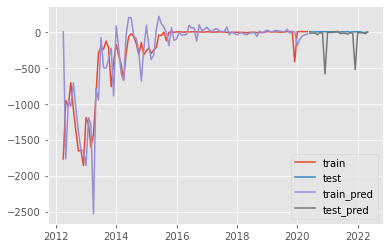

In [113]:
y_hat_train = sari_mod.predict(typ='levels')
y_hat_test = sari_mod.predict(start=test.index[0], end=test.index[-1],typ='levels')

fig, ax = plt.subplots()
ax.plot(train, label='train')
ax.plot(test, label='test')
ax.plot(y_hat_train, label='train_pred')
ax.plot(y_hat_test, label='test_pred')

plt.legend();

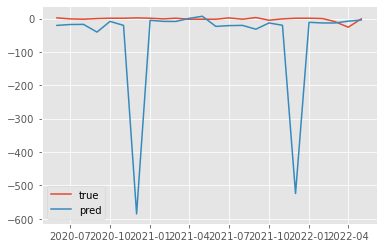

In [114]:
# Let's zoom in on test
fig, ax = plt.subplots()

ax.plot(test, label='true')
ax.plot(y_hat_test, label='pred')

plt.legend();

In [115]:
np.sqrt(mean_squared_error(test, y_hat_test))

161.82584805016552

The rmse has reduced significantly from random walk rmse of 262.68 to SRIMAX model rmse of 161.83

### Forecast with final model 

Lastly, let's predict into the future.

To do so, we'll refit to our entire training set.

In [117]:
sari_mod = SARIMAX(ts_new,
                  order=(0, 1, 1),
                  seasonal_order=(1, 1, 1, 12),
                  enforce_stationarity=False,
                  enforce_invertibility=False).fit()

In [118]:
forecast = sari_mod.forecast(steps=12)

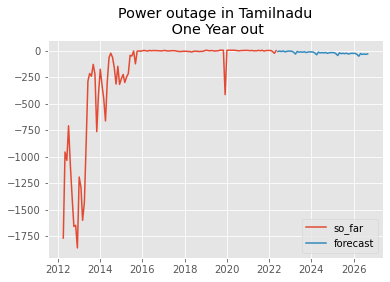

In [120]:
fig, ax = plt.subplots()
ax.plot(ts_new, label='so_far')
ax.plot(forecast, label='forecast')
ax.set_title('Power outage in Tamilnadu\n One Year out')

plt.legend();